In [1]:
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io, color
from skimage.transform import resize
import math


In [23]:
image_name = "Alamar, Ciudad De La Habana, Cuba - Sunset 8:11pm.jpg"
img_dir = "./data/downloaded/ericcahan/" + image_name


# img_dir = "./data/Lenna.png"

In [3]:
def get_df_rgb(img):
    image = img
    if isinstance(img, str):
        image = Image.open(img)
    
    n_dims = np.array(image).shape[-1]
    pixel_values = np.array(image).reshape(-1, n_dims)
    
    # Convert normalized values to 0-255 range if necessary
    if pixel_values.max() <= 1.0:
        pixel_values *= 255
    
    r, g, b = pixel_values.T
    return pd.DataFrame({'r': r, 'g': g, 'b': b})

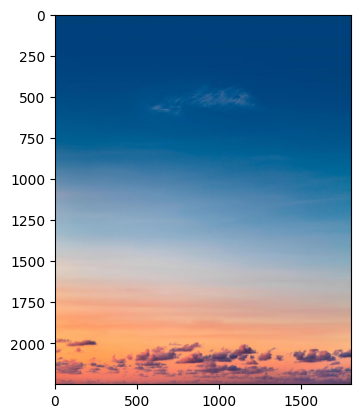

(4050000, 3)


In [4]:
File_name = mpimg.imread(img_dir)
plt.imshow(File_name)
plt.show()

# plt.imshow(image)
# image.show()
rgb_values = get_df_rgb(File_name)
print(rgb_values.shape)

In [5]:
rgb_array = rgb_values.values

# Initialize the PCA model with 2 components
pca = PCA(n_components=2)

# Fit the PCA model to your data
pca.fit(rgb_array)

# Transform the RGB values to the first two principal components
pca_components = pca.transform(rgb_array)


In [6]:
rgb_values.head()

,r,g,b
0,0,65,121
1,0,65,121
2,0,65,121
3,0,65,121
4,0,65,121


In [7]:
np.min(rgb_array, axis=0)

array([ 0, 43, 67], dtype=uint8)

Sort rgb values according to pca_1 value

In [8]:
print(pca_components)

[[-117.04600605   22.52458682]
 [-117.04600605   22.52458682]
 [-117.04600605   22.52458682]
 ...
 [ -35.15130914   66.6558524 ]
 [ -35.15130914   66.6558524 ]
 [ -32.3553381    64.62549156]]


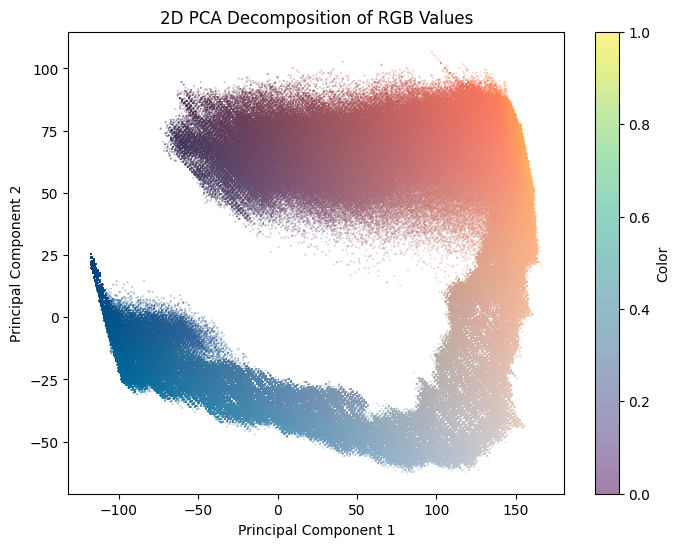

In [9]:
# Create a DataFrame for the transformed PCA components
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])

# Plot the 2D PCA decomposition with colored points
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=rgb_array/255.0, alpha=0.5, s=0.1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Decomposition of RGB Values')
plt.colorbar(label='Color')
plt.show()

In [10]:
center_pos = np.mean(pca_components, axis=0)

print(center_pos)

[4.20287802e-11 3.03947365e-11]


In [11]:
min_pc1_index = np.argmin(pca_components[:,0])
min_pc1 = np.min(pca_components[:,0])
print(min_pc1)
print(min_pc1_index)

print(pca_components[min_pc1_index,0])

-117.69955721547232
579192
-117.69955721547232


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[241.41846908 163.64955454 125.71754447]
[181.14737976 102.24343168 106.49553609]
[125.74850444  79.51438153 103.67626443]
[ 90.35784962  66.41151794 100.36049428]
[  0.37819281  68.76764375 127.37048275]
[ 15.47113152  99.50716451 150.27070838]
[ 69.47397248 129.23887987 171.1300094 ]
[ 91.3529313  141.54915769 179.23519089]
[127.41947336 162.57780886 191.15302008]
[192.54553758 187.52944938 189.77547202]


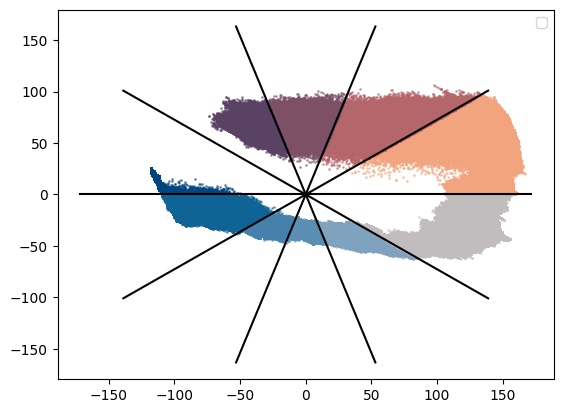

In [21]:
# Using simple mean
# Calculate center
center = np.mean(pca_components, axis=0)

closet_index = np.argmin(np.linalg.norm(pca_components - center, axis=1))

center_color = rgb_array[closet_index]

# Calculate angles (starting from x axis)
angles = np.arctan2(pca_components[:,1] - center[1], pca_components[:,0] - center[0])
angles = np.mod(angles, 2 * np.pi)
# sort angles
sorted_indices = np.argsort(angles)

# reorder angles
angles = angles[sorted_indices]

# Calculate distances
distances = np.sqrt((pca_components[:,0] - center[0])**2 + (pca_components[:,1] - center[1])**2)
max_distance = np.max(distances)

# Create lines
num_segments = 10
segment_angles = np.linspace(0, 2 * np.pi, num_segments, endpoint=False)
segment_degrees = np.rad2deg(segment_angles)
segment_lines = [(center[0], center[1], max_distance * np.cos(a), max_distance *  np.sin(a)) for a in segment_angles]

# Determin points inside segments
points_inside_segments = []
for a1, a2 in zip(segment_angles, np.roll(segment_angles, -1)):
    if a2 > a1:
        points_inside = sorted_indices[(angles >= a1) & (angles < a2)]
    else:
        points_inside = sorted_indices[(angles >= a1) | (angles < a2)]
        if a1 > 2 * np.pi - (a2 - a1):
            points_inside = sorted_indices[(angles >= a1) & (angles < a2) | (angles < a2 - 2 * np.pi)]
    points_inside_segments.append(points_inside)



pca_components_x = pca_components[:,0]
pca_components_y = pca_components[:,1]

cmap = plt.get_cmap('viridis')  # You can choose a different colormap


segment_colors = []

# Plot
# plt.scatter(pca_components_x, pca_components_y, c='black', label="Original data")
for i, line in enumerate(segment_lines):
    plt.plot([line[0], line[0] + line[2]], [line[1], line[1] + line[3]], color='black')

    # Scatter plot with points inside segments colored based on the segment
    # segment_color = segment_colors(i)
    segment_distances = distances[points_inside_segments[i]]
    colors_inside_segment = rgb_array[points_inside_segments[i]]
    # biggest_distance_idx = np.argmax(segment_distances)
    # segment_color = colors_inside_segment[biggest_distance_idx]
    segment_color = np.mean(colors_inside_segment, axis=0)
    # closet_index = np.argmin(np.linalg.norm(colors_inside_segment - segm, axis=1))
    # farthest_color = np.argmax(colors_inside_segment - center_color, axis=0)
    # print(farthest_color)
    # print(segment_color)
    # segment_color = segment_colors(i)
    print(segment_color)
    segment_colors.append({
        "r": segment_color[0],
        "g": segment_color[1],
        "b": segment_color[2]
    })
    plt.scatter(pca_components_x[points_inside_segments[i]], pca_components_y[points_inside_segments[i]],\
                 color=segment_color/255, alpha=0.5, s=1)
    
plt.legend()
plt.show()




In [22]:


for color in segment_colors:
    print(color)

# create json of that image


{'r': 241.418469080238, 'g': 163.64955454269753, 'b': 125.7175444688136}
{'r': 181.14737975795708, 'g': 102.24343168097951, 'b': 106.49553609386957}
{'r': 125.74850444135598, 'g': 79.51438153362741, 'b': 103.67626442685359}
{'r': 90.3578496192604, 'g': 66.41151794263827, 'b': 100.36049427750673}
{'r': 0.37819280636124236, 'g': 68.76764375202902, 'b': 127.37048274568741}
{'r': 15.471131520709093, 'g': 99.50716451325685, 'b': 150.27070837782824}
{'r': 69.47397247664196, 'g': 129.23887986639403, 'b': 171.1300094023894}
{'r': 91.35293130283517, 'g': 141.54915768913847, 'b': 179.23519089327678}
{'r': 127.41947336043907, 'g': 162.57780885646451, 'b': 191.15302007939482}
{'r': 192.54553757957189, 'g': 187.52944938392264, 'b': 189.77547201988764}


In [24]:
import json

# Create a Python dictionary
data = {}
data[image_name] = segment_colors

# Convert the dictionary to a JSON string
json_data = json.dumps(data)

# Print the JSON string
print(json_data)

# Save the JSON string to a file
with open("data.json", "w") as json_file:
    json.dump(data, json_file)

{"Alamar, Ciudad De La Habana, Cuba - Sunset 8:11pm.jpg": [{"r": 241.418469080238, "g": 163.64955454269753, "b": 125.7175444688136}, {"r": 181.14737975795708, "g": 102.24343168097951, "b": 106.49553609386957}, {"r": 125.74850444135598, "g": 79.51438153362741, "b": 103.67626442685359}, {"r": 90.3578496192604, "g": 66.41151794263827, "b": 100.36049427750673}, {"r": 0.37819280636124236, "g": 68.76764375202902, "b": 127.37048274568741}, {"r": 15.471131520709093, "g": 99.50716451325685, "b": 150.27070837782824}, {"r": 69.47397247664196, "g": 129.23887986639403, "b": 171.1300094023894}, {"r": 91.35293130283517, "g": 141.54915768913847, "b": 179.23519089327678}, {"r": 127.41947336043907, "g": 162.57780885646451, "b": 191.15302007939482}, {"r": 192.54553757957189, "g": 187.52944938392264, "b": 189.77547201988764}]}
